Libraries:

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import DraperQFTAdder

# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

C:\Users\brayd\AppData\Local\Temp\ipykernel_13504\50878126.py:12: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Functions:

In [2]:
# Function performs QFT on first n qubits in the circuit
def qft_rotations(qc, n):

    if n == 0:
        return qc
    
    n -= 1
    qc.h(n)
    
    for qubit in range(n):
        qc.cp(pi/2**(n-qubit), qubit, n)
        
    qft_rotations(qc, n)

In [3]:
# Reverse order of qubits to match definition
def swap_registers(qc, n):
    
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
        
    return qc

In [4]:
# Performs QFT on first n qubits
def qft(qc, n):
    
    qft_rotations(qc, n)
    swap_registers(qc, n)
    
    return qc

In [5]:
# Performs IQFT on first n qubits
def inverse_qft(qc, n):

    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    qc.append(invqft_circ, qc.qubits[:n])
    
    return qc.decompose() 

In [6]:
# Encodes an integer to binary and places it into the quantum circuit
def encode_integer(num):
    
    # Calculate the number of qubits needed to represent the integer
    nqubits = num.bit_length()

    # Create a quantum circuit with the required number of qubits
    qc = QuantumCircuit(nqubits)

    # Encode the integer using Pauli-X gates
    for i, bit in enumerate(reversed(bin(num)[2:])):
        if bit == '1':
            qc.x(i)

    return qc, nqubits

Testing the Circuit:

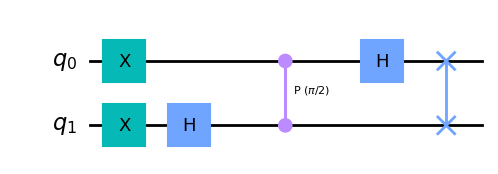

In [7]:
number = 3
qc, nqubits = encode_integer(number)
qc = qft(qc,nqubits)
qc.draw('mpl')

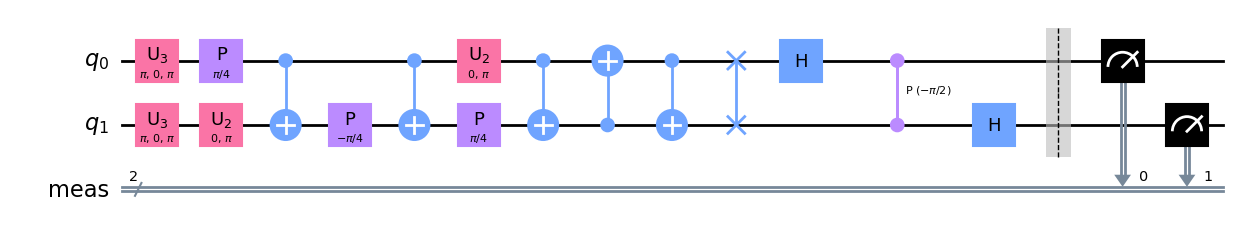

In [8]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw('mpl')

Results:

In [9]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


Job Status: job has successfully run


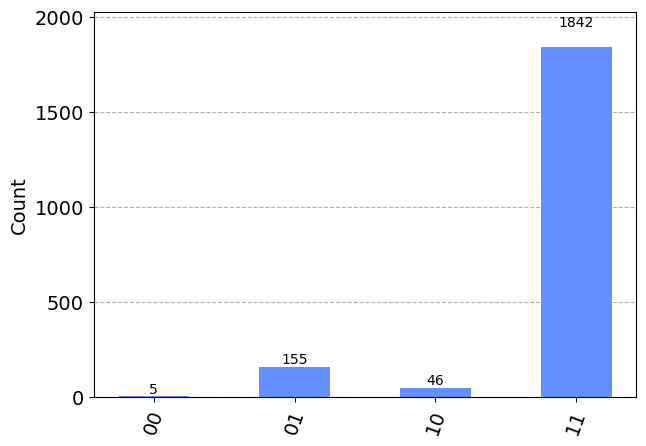

In [10]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)